In [2]:
# !pip3 install rdkit xgboost lightgbm catboost mlxtend optuna hyperopt

import tqdm
import pickle
import warnings
import itertools
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from pk.utils import threshold_analysis, heatmap
from pk.file_handling import read_pk_dataset, read_pk_dataset_with_split
from pk.preprocessing import calc_high_corr_feats, calc_low_variance_feats, scale_columns
from pk.features import morgan_fingerprint
from pk.model_selection import randomized_search, CrossValidator
from pk.metrics import binary_classification_metrics
from pk.confidence import delong_confidence_intervals
from pk.search_spaces import hyperopt_space, random_search_space
from pk.optimizers import HyperoptOptimizer, OptunaOptimizer, optimize_models
from pk.model_comparison import compare_models_optimizers_on_split, hypothesis_test_multiple_comparison

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

tqdm.tqdm.pandas()

In [3]:
DATA_PATH = '../data/updatedPK.csv'

TRAIN_PATH = '../data/pk_60_40_training_seed42.csv'
VAL_PATH = '../data/pk_60_40_cv_seed42.csv'
TEST_PATH = '../data/pk_60_40_et_seed42.csv'

MODE = 'bin_class'

TEST_SIZE = 0.2
CROSS_VALIDATION_K = 5
FP_NBITS = 64
CORR_THRESH = 0.95
VAR_THRESH = 0.1
RANDOM_STATE = 42
RANDOM_SEED = 0

assert MODE in ('bin_class', 'reg', 'cat_class'), \
    f"MODE, '{MODE}' is invalid."

np.random.seed(RANDOM_SEED)

### Read Data

In [4]:
df_base, remove_cols = read_pk_dataset(DATA_PATH, mode=MODE, verbose=False)
df_trn, df_val, df_tst, _ = \
    read_pk_dataset_with_split(TRAIN_PATH, TEST_PATH, 
                               val_path=VAL_PATH, 
                               mode=MODE, ycol='AUC1', 
                               verbose=False)

def predefined_split(df, split):
    df_trn, df_val, df_tst = split
    
    df_train = df[df['mol'].isin(df_trn['mol'].values)]
    df_valid = df[df['mol'].isin(df_val['mol'].values)]
    df_test = df[df['mol'].isin(df_tst['mol'].values)]
    
    df_train = pd.concat([df_train, df_valid])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    assert set(df_test['mol']) == set(df_tst['mol'])
    assert set(df_train['mol']) == set(df_trn['mol']).union(set(df_val['mol']))
    assert not df_train['mol'].isnull().sum() and not df_test['mol'].isnull().sum()
    assert df_train['mol'].is_unique and df_test['mol'].is_unique
    
    return df_train, df_test

df_train, df_test = predefined_split(df_base, [df_trn, df_val, df_tst])

df_et = pd.read_csv('../data/external_test.csv')
df_et.rename({'SMILES': 'mol'}, axis=1, inplace=True)

### Pipeline 1 (Khadija's Work)

In [5]:
X_trn_p1, y_trn_p1 = df_trn.drop(['mol', 'AUC', 'AUC_bin'], axis=1), df_trn['AUC_bin']
X_val_p1, y_val_p1 = df_val.drop(['mol', 'AUC', 'AUC_bin'], axis=1), df_val['AUC_bin']
X_tst_p1, y_tst_p1 = df_tst.drop(['mol', 'AUC', 'AUC_bin'], axis=1), df_tst['AUC_bin']

### Pipeline 2 (Vedang's Work)

In [6]:
class FeatureEngineeringPipeline:
    
    def __init__(self, corr_thresh, var_thresh, fp_n_bits):
        self.corr_thresh = corr_thresh
        self.var_thresh = var_thresh
        self.fp_n_bits = fp_n_bits
        
        self.ycol = None
        self.scaler = None
        self.cross_validator = None  # Not really used during inference
        self.final_col_set = None
        self.is_fit = False
        
    def fit_transform(self, df_train, df_test, remove_cols, ycol='AUC_bin'):
        warnings.filterwarnings('ignore')
        
        # Create a copy to avoid changing original data
        df_trn, df_tst = df_train.copy(), df_test.copy()
    
        # Remove high correlation features
        high_corr_feats = calc_high_corr_feats(df_train, 
                                               remove_cols, 
                                               threshold=self.corr_thresh)
        remove_cols.update(high_corr_feats)

        # Remove low variance features
        low_var_feats = calc_low_variance_feats(df_train,
                                                remove_cols,
                                                threshold=self.var_thresh)
        remove_cols.update(low_var_feats)

        # Scale columns
        df_train_scaled, df_test_scaled, scaler = scale_columns(df_train, 
                                                                df_test, 
                                                                list(remove_cols))

        # Add morgan fingerprints
        df_train_scaled = morgan_fingerprint(df_train_scaled, n_bits=self.fp_n_bits)
        df_test_scaled = morgan_fingerprint(df_test_scaled, n_bits=self.fp_n_bits)

        # Create train and test sets
        X_train, y_train = df_train_scaled.drop(remove_cols, axis=1), df_train_scaled[ycol]
        X_test, y_test = df_test_scaled.drop(remove_cols, axis=1), df_test_scaled[ycol]

        # Remove zero importance features
        cv = CrossValidator()
        cv.fit(X_train, y_train)
        
        remove_cols.update(cv.zero_imp_feats())
        X_train.drop(cv.zero_imp_feats(), axis=1, inplace=True)
        X_test.drop(cv.zero_imp_feats(), axis=1, inplace=True)
        
        # Set the is_fit flag
        self.is_fit = True
        
        # Save objects to memory
        self.ycol = ycol
        self.scaler = scaler
        self.cross_validator = cv
        self.final_col_set = set(X_train.columns)

        return X_train, y_train, X_test, y_test, remove_cols
    
    def transform(self, df_infer):
        if not self.is_fit:
            raise ValueError(f"Object is not fit yet!")
            
        if self.ycol not in df_infer.columns:
            warnings.warn(f"Label column, {self.ycol} not present in inference set.")
            
        # Copy data to avoid changing it
        df = df_infer.copy()
        
        # Add morgan fingerprint
        df = morgan_fingerprint(df, n_bits=self.fp_n_bits)
        
        # Check if all columns are present
        if self.final_col_set - set(df.columns):
            raise ValueError(f"Inference set doesn't have the following columns: {self.final_col_set - set(df_infer.columns)}.")
        
        to_scale = set(self.scaler.feature_names_in_).intersection(self.final_col_set)
        scale_extra = set(self.scaler.feature_names_in_) - self.final_col_set
        
        df_scale, df_not_scale = df[to_scale], df[self.final_col_set - to_scale]
        
        for col in scale_extra:
            df_scale[col] = 0.
            
        scale_cols = df_scale.columns
        
        df_scaled = self.scaler.transform(df_scale)
        df_scaled = pd.DataFrame(df_scaled, columns=scale_cols)
        
        df_scaled.drop(scale_extra, axis=1, inplace=True)
        
        df_combined = pd.concat([df_scaled, df_not_scale], axis=1)
        
        return df_combined

In [7]:
fep_2 = FeatureEngineeringPipeline(corr_thresh=CORR_THRESH, var_thresh=VAR_THRESH, fp_n_bits=FP_NBITS)

X_train, y_train, X_test, y_test, remove_cols = fep_2.fit_transform(df_train, df_test, remove_cols)

In [8]:
X_trn_p2, X_val_p2, y_trn_p2, y_val_p2 = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)
X_tst_p2, y_tst_p2 = X_test.copy(), y_test.copy()

X_et_2 = fep_2.transform(df_et)
assert set(X_trn_p2.columns) == set(X_et_2.columns)

In [9]:
from catboost import Pool

In [21]:
with open('../data/pipeline_2_trained_models.pkl', 'rb') as f:
    data = pickle.load(f)

In [25]:
data['test_metrics']

,model,auroc,lb,ub,thresh_values
4,RandomForestClassifier/optuna/P2,93.075,0.0,100.0,"{'best_f1_thresh': 0.5344716494845361, 'best_p..."
8,RandomForestClassifier/random_search/P2,91.136,0.0,100.0,"{'best_f1_thresh': 0.49800086580086567, 'best_..."
0,RandomForestClassifier/hyperopt/P2,90.859,0.0,100.0,"{'best_f1_thresh': 0.5025820155903867, 'best_p..."
11,CatBoostClassifier/random_search/P2,89.751,0.0,100.0,"{'best_f1_thresh': 0.35522941285698617, 'best_..."
3,CatBoostClassifier/hyperopt/P2,87.535,0.0,100.0,"{'best_f1_thresh': 0.20063808547328343, 'best_..."
6,LGBMClassifier/optuna/P2,87.535,0.0,100.0,"{'best_f1_thresh': 0.9997696953442468, 'best_p..."
9,XGBClassifier/random_search/P2,87.258,0.0,100.0,"{'best_f1_thresh': 0.5185603499412537, 'best_p..."
5,XGBClassifier/optuna/P2,86.981,0.0,100.0,"{'best_f1_thresh': 0.49177294969558716, 'best_..."
7,CatBoostClassifier/optuna/P2,86.704,0.0,100.0,"{'best_f1_thresh': 0.14490841663614248, 'best_..."
1,XGBClassifier/hyperopt/P2,85.873,0.0,100.0,"{'best_f1_thresh': 0.4318983852863312, 'best_p..."


In [41]:
best_params = data['trained_models']['CatBoostClassifier/random_search/P2'].get_params()

In [42]:
def virt_ensemble(X_train, y_train, X_test, params=None, num_samples=10, iters=1000, lr=0.2):
    ens_preds = []
    
    if params is None:
        model = CatBoostClassifier(iterations=iters, 
                                   learning_rate=lr, 
                                   loss_function='Logloss',
                                   posterior_sampling=True, 
                                   verbose=False, 
                                   random_seed=0)
    else:
        params['posterior_sampling'] = params.get('posterior_sampling', True)
        model = CatBoostClassifier(**params)
    
    model.fit(X_train, y_train)
    
    ens_preds = model.virtual_ensembles_predict(X_test, prediction_type='TotalUncertainty', 
                                                virtual_ensembles_count=num_samples)
    return np.asarray(ens_preds)

In [43]:
X, y = pd.concat([X_trn_p2, X_val_p2, X_tst_p2]), np.concatenate([y_trn_p2, y_val_p2, y_tst_p2])

In [44]:
ens_preds = virt_ensemble(X, y, X_et_2, params=best_params)

In [56]:
total_unc, data_unc = ens_preds[:, 1], ens_preds[:, 0]
knowledge_unc = total_unc - data_unc

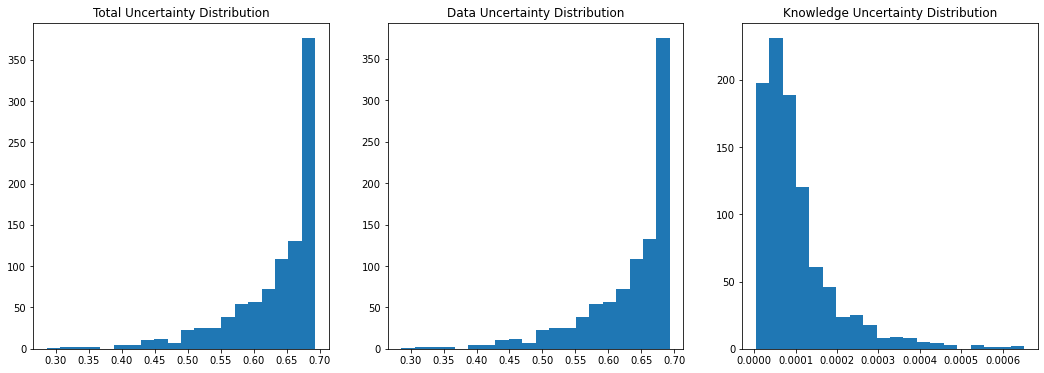

In [59]:
bins = 20
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].hist(total_unc, bins=bins)
axes[1].hist(data_unc, bins=bins)
axes[2].hist(knowledge_unc, bins=bins)

axes[0].set_title('Total Uncertainty Distribution')
axes[1].set_title('Data Uncertainty Distribution')
axes[2].set_title('Knowledge Uncertainty Distribution')

plt.show()